# Random walks $R_t$ factor with constant decay and Gamma-Poisson likelihood

In [ ]:
# NOTE: run this once
# !curl -o all_data.csv https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv

In [1]:
from datetime import date
import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
import theano.tensor as tt

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5]})

In [3]:
all_data = pd.read_csv(
    'all_data.csv',
    usecols=['Date', 'Country/Region', 'Confirmed'],
    parse_dates=['Date'],
    infer_datetime_format=True,
)

all_data = all_data.merge(all_data, on='Country/Region', suffixes=['_prev', ''])

all_data = all_data[(all_data.Date - all_data.Date_prev).dt.days == 1]
all_data = all_data.assign(new_cases = (all_data.Confirmed - all_data.Confirmed_prev).fillna(0).astype('int'))
all_data = all_data[['Date', 'Country/Region', 'new_cases']]

In [4]:
# selecting data from single country, from the last date without cases
country = 'Germany'
data = all_data[all_data['Country/Region'] == country]
data = data.set_index('Date').sort_index().new_cases.iloc[3:]
data.head(5)

Date
2020-01-26    0
2020-01-27    1
2020-01-28    3
2020-01-29    0
2020-01-30    0
Name: new_cases, dtype: int64

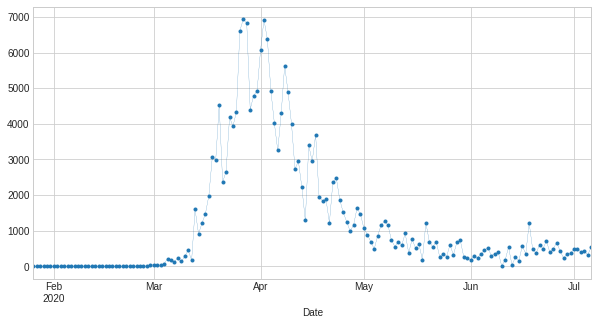

In [5]:
data.plot(linewidth=0.2, marker='.')
None

## Model:

The goal of the model is to estimate the R factor by fitting the new daily cases.

We assume there is an over-dispersion in the count, so we use Gamma-Poisson likelihood (Negative Binomial):

$$ \text{observed}_t \sim \text{NB}(\lambda_t, \alpha) $$

The poisson parameter satisfies the equation:

$$ \lambda_t = \lambda_{t-1} \exp(R_t - \gamma) $$

that is, in closed form:

$$ \log \lambda_t = \log \lambda_{0} - t \gamma + \Sigma_{\tau=1}^t R_{\tau} $$

where $\gamma$ is a positive decay rate:

$$\gamma \sim \text{Exponential}(1) $$

The $R$ factor varies daily on the log-scale:

$$ \log(R_t) \sim \mathcal{N}(\log(R_{t-1}), \sigma^2) $$

Optionally, we can put a constraining prior over $\sigma$

$$\sigma \sim \text{Exponential}(1) $$

Finally, we put a non-informative prior over the dispersion parameter $\alpha$:

$$ \alpha \sim \text{HalfCauchy}(1) $$

In [10]:
N = data.shape[0]

with pm.Model() as model:

#     sigma = pm.Exponential('sigma', 1)
    sigma = 1
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 20),
        sigma=sigma,
        shape=N
    )

    # spread
    R = pm.Deterministic('R', pm.math.exp(logR))

    # fixed daily decay
    gamma = pm.Exponential('gamma', 1)

    init_log_lam = -10
    log_lam = init_log_lam + tt.cumsum(R) - np.arange(0, N) * gamma
    lam = pm.Deterministic('lambda', pm.math.exp(log_lam))

    alpha = pm.HalfCauchy('alpha', 1)
    pm.NegativeBinomial('obs', mu=lam, alpha=alpha, observed=data.values)

    trace = pm.sample(5000, tune=5000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, gamma, logR]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 322 seconds.
There were 2925 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1319 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


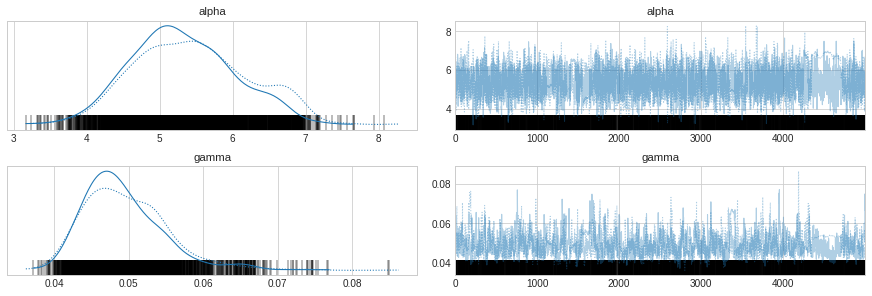

In [12]:
pm.traceplot(trace, var_names=['alpha', 'gamma'])
None

/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


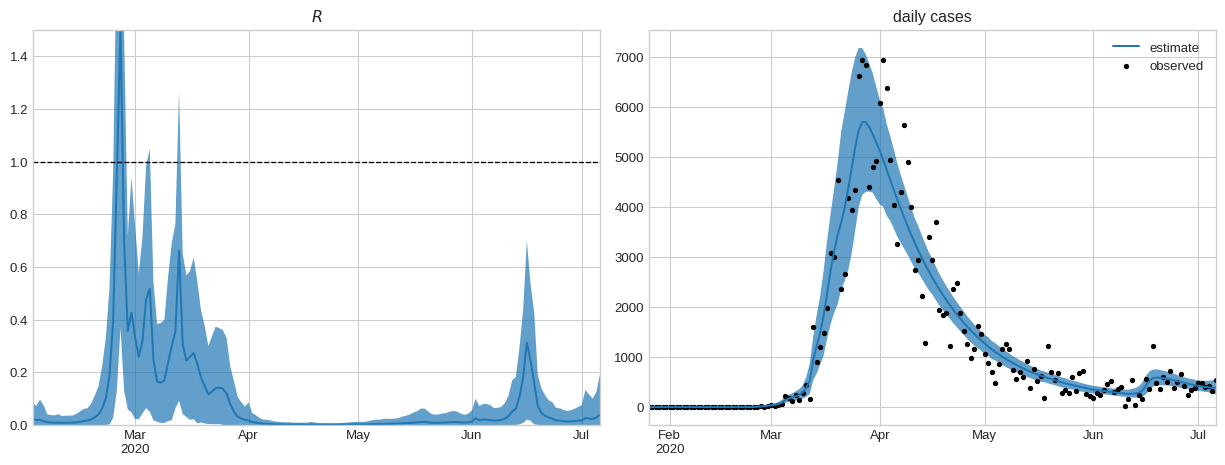

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), dpi=95)

tmp = pm.hpd(trace['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.reset_index()['Date'])
tmp = tmp.assign(mean_ = trace['R'].mean(axis=0))
tmp = tmp.iloc[7:]
tmp.mean_.plot(ax=ax1)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.7)
ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R$', xlabel='', ylim=(0, 1.5))

tmp = pm.hpd(trace['lambda'], hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.reset_index()['Date'])
tmp = tmp.assign(mean_ = trace['lambda'].mean(axis=0))

tmp.mean_.plot(label='estimate')
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.7)
ax2.scatter(tmp.index, data, color='k', label='observed', marker='.')
ax2.set(title='daily cases', xlabel='')
ax2.legend()

fig.tight_layout()
None